In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

import sklearn.metrics as skmetr
import xgboost as xgb
from xgboost import plot_importance

In [42]:
def print_errors(y_true, y_pred, msg):
    print('ERRORS in ' + msg)
    print('MAE: {0}'.format(skmetr.mean_absolute_error(y_true, y_pred)))
    print('RMSE: {0}'.format(np.sqrt(skmetr.mean_squared_error(y_true, y_pred))))
    print('MAPE: {0}'.format(np.mean(np.absolute(y_true - y_pred)/(y_true+1)*100)))
    print('RMSPE: {0}'.format(np.sqrt(np.mean(np.square(((y_true - y_pred) /(y_true+1))), axis=0))))

In [43]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [44]:
rossman_df = pd.read_csv('data/train.csv').reset_index(drop=True)
rossman_df.Date = pd.to_datetime(rossman_df.Date)

stores = pd.read_csv('data/store.csv').reset_index(drop=True)

rossman_df = pd.merge(rossman_df, stores, how='left', on='Store')
rossman_df = rossman_df[~((rossman_df.Sales<1)&(rossman_df.Open==1))]
rossman_df = rossman_df[rossman_df.Sales>0]

rossman_df.head()

/home/trix_arch/.conda/envs/minicomp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
27,2013-01-01,353.0,2.0,3139.0,820.0,1.0,0.0,a,1.0,b,b,900.0,NaN,NaN,1.0,14.0,2013.0,"Feb,May,Aug,Nov"
115,2013-01-01,335.0,2.0,2401.0,482.0,1.0,0.0,a,1.0,b,a,90.0,NaN,NaN,1.0,31.0,2013.0,"Jan,Apr,Jul,Oct"
147,2013-01-01,512.0,2.0,2646.0,625.0,1.0,0.0,a,1.0,b,b,590.0,NaN,NaN,1.0,5.0,2013.0,"Mar,Jun,Sept,Dec"
162,2013-01-01,494.0,2.0,3113.0,527.0,1.0,0.0,a,1.0,b,a,1260.0,6.0,2011.0,0.0,NaN,NaN,NaN
199,2013-01-01,530.0,2.0,2907.0,532.0,1.0,0.0,a,1.0,a,c,18160.0,NaN,NaN,0.0,NaN,NaN,NaN


In [45]:
def add_time_features(df):
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['DayOfWeek'] = df.Date.dt.dayofweek
    df['WeekOfYear'] = df.Date.dt.weekofyear
    return df

def recode(df, var_list=[]):
    map_dict = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    for v in var_list:
        df[v].replace(map_dict, inplace=True)
    return df   

In [46]:
# incorporate the new features
rossman_df = add_time_features(rossman_df)
rossman_df = recode(rossman_df, ['StoreType', 'Assortment', 'StateHoliday'])

rossman_df.head()

/tmp/ipykernel_5723/3415238186.py:6: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
27,2013-01-01,353.0,1,3139.0,820.0,1.0,0.0,1.0,1.0,2.0,...,NaN,NaN,1.0,14.0,2013.0,"Feb,May,Aug,Nov",2013,1,1,1
115,2013-01-01,335.0,1,2401.0,482.0,1.0,0.0,1.0,1.0,2.0,...,NaN,NaN,1.0,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
147,2013-01-01,512.0,1,2646.0,625.0,1.0,0.0,1.0,1.0,2.0,...,NaN,NaN,1.0,5.0,2013.0,"Mar,Jun,Sept,Dec",2013,1,1,1
162,2013-01-01,494.0,1,3113.0,527.0,1.0,0.0,1.0,1.0,2.0,...,6.0,2011.0,0.0,NaN,NaN,NaN,2013,1,1,1
199,2013-01-01,530.0,1,2907.0,532.0,1.0,0.0,1.0,1.0,1.0,...,NaN,NaN,0.0,NaN,NaN,NaN,2013,1,1,1


In [47]:
print( rossman_df.Date.min() )
print( rossman_df.Date.max() )
rossman_df = rossman_df.sort_values('Date').reset_index(drop=True)

val_start = '2014-04-01'
rossman_df['dataset_type'] = ''
rossman_df.loc[rossman_df.Date < val_start, 'dataset_type'] = 'train'
rossman_df.loc[rossman_df.Date >= val_start, 'dataset_type'] = 'validation'

train_df = rossman_df[rossman_df.dataset_type == 'train']
val_df = rossman_df[rossman_df.dataset_type == 'validation']

# train_df.head()
# val_df.head()

2013-01-01 00:00:00
2014-07-31 00:00:00


In [48]:
# fig = px.line(
#     train_df[(train_df.Store<5)&(train_df.Sales>0)], 
#     x='Date', y="Sales", 
#     color='Store', 
#     title="Sales per store - training data",  
#     width=800, height=500,
#     hover_data = ['Open','Promo','StateHoliday','SchoolHoliday'])

# fig.show()

In [49]:
feat_dict = {'only_time' : ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek', 'StateHoliday', 'SchoolHoliday', 'Open'],
             'only_comp' : ['CompetitionDistance', 'Promo2', 'Open', 'Promo'],
             'only_store' : ['StoreType', 'Assortment', 'Open'],
             'all_feat' : ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek','StateHoliday', 'SchoolHoliday', 
                           'CompetitionDistance', 'Promo2', 'StoreType', 'Assortment', 'Open', 'Promo']}
vars_list = feat_dict['all_feat']

dtrain = xgb.DMatrix(train_df[vars_list], label=train_df['Sales'])
deval = xgb.DMatrix(val_df[vars_list], label=val_df['Sales'])

In [50]:
params = {"objective": "reg:squarederror", 
          "booster" : "gbtree", 
          "seed": 10 }
num_of_trees = 10

xgb_model_MK1 = xgb.train(params, dtrain, 
                      num_boost_round=num_of_trees,
                      early_stopping_rounds=20, 
                      evals=[(deval, "Eval")], 
                      verbose_eval=False)

In [51]:

pred = xgb_model_MK1.predict(deval)
print_errors(val_df['Sales'], pred, 'test dataset')

ERRORS in test dataset
MAE: 1796.0634591095295
RMSE: 2527.5959579637433
MAPE: 26.917953916122567
RMSPE: 0.3780086738117436


In [52]:
params_upd1 = {"objective": "reg:squarederror", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "seed": 10                
          }
num_of_trees = 20
early_stopping_rounds_N=20

xgb_model_MK2 = xgb.train(
                          params_upd1, 
                          dtrain, 
                          num_boost_round=num_of_trees,
                          early_stopping_rounds=early_stopping_rounds_N, 
                          evals=[(deval, "Eval")], 
                          verbose_eval=False
                         )

In [53]:
pred_MK2 = xgb_model_MK2.predict(deval)
print_errors(val_df['Sales'], pred_MK2, 'test dataset')

ERRORS in test dataset
MAE: 4002.291235270705
RMSE: 4829.478433012039
MAPE: 51.261500183334704
RMSPE: 0.5352667228401103


In [54]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [55]:
metric(pred_MK2, val_df.Sales.to_numpy())

53.53417493291908

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

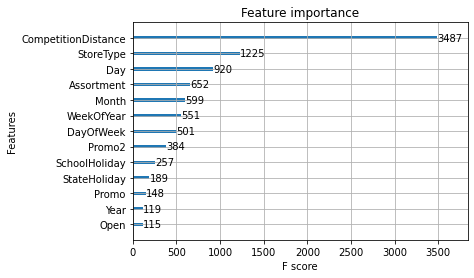

In [56]:
plot_importance(xgb_model_MK2)